<a href="https://colab.research.google.com/github/jacKlinc/movie_review_sentiment/blob/main/notebooks/1_mdl_nlp_train_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook

     |████████████████████████████████| 727kB 12.2MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 1.2MB 28.7MB/s 
     |████████████████████████████████| 194kB 55.0MB/s 
     |████████████████████████████████| 61kB 10.8MB/s 


In [2]:
from fastbook import *

# ImDB Movie Review Sentiment Analysis
I want to predict whether a user's review is negative or postive based on the text they type. The idea behind this approach is to first use transfer learning with the Wikipedia model which has all its articles, this teaches the model how sentences are structured and what words come after what. The next step is to train on an imDB model, this introduces the model to words specific to film making, giving the model the domain specfic language to read reviews.

---

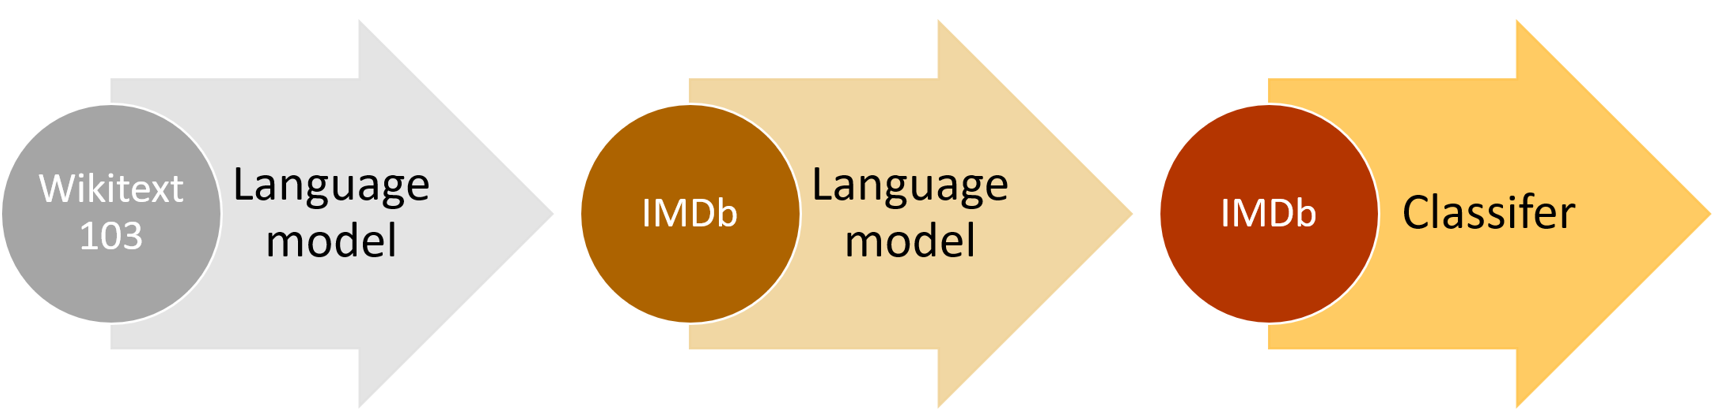

---

#### TODO
- [x] Tokenise words
- [x] Numericalise
- [ ] Preprocess data
- [ ] Train on imDB

## Tokenisation
This step converts a text corpus into something a computer can more easily understand. The main change is how punctuation and capital letters are handled, which seem pretty complicated to a computer. 

FastAI does not tokenise the words rather uses Spacy which is quite popular.

Import imDB dataset.

In [3]:
from fastai.text.all import *
path = untar_data(URLs.IMDB)

In [4]:
files = get_text_files(path, folders=['train', 'test', 'unsup'])

In [5]:
txt = files[0].open().read()
txt[:60]

"Jim Varney's performances as the Harem Girl and A.U. are ama"

### Word Tokeniser

In [6]:
spacy = WordTokenizer()
toks = first(spacy([txt]))
print(coll_repr(toks, 30))

(#90) ['Jim','Varney',"'s",'performances','as','the','Harem','Girl','and','A.U.','are','amazingly','funny','--','on','a','level','surpassing','Chaplin','and','Keaton','.','Linda','Kash','is','great','in','her','once','-'...]


The above step splits all words like "it's" into "it" and "s".

In [7]:
tokeniser = Tokenizer(spacy)
print(coll_repr(tokeniser(txt), 30))

(#107) ['xxbos','xxmaj','jim','xxmaj','varney',"'s",'performances','as','the','xxmaj','harem','xxmaj','girl','and','xxup','a.u','.','are','amazingly','funny','--','on','a','level','surpassing','xxmaj','chaplin','and','xxmaj','keaton'...]


This step adds special tokens for things like the beginning and end of sentences. Below are some examples:
- `xxbos` is the beginning of a text stream
- `xxmaj` is a capital letter


Data is rarely clean and this also applies to the review data where things like HTML fragements and emtpy spaces are present. Luckily, FastAI provides some rules to help

In [8]:
defaults.text_proc_rules

[<function fastai.text.core.fix_html>,
 <function fastai.text.core.replace_rep>,
 <function fastai.text.core.replace_wrep>,
 <function fastai.text.core.spec_add_spaces>,
 <function fastai.text.core.rm_useless_spaces>,
 <function fastai.text.core.replace_all_caps>,
 <function fastai.text.core.replace_maj>,
 <function fastai.text.core.lowercase>]

In [9]:
coll_repr(tokeniser('&amp'))

"(#2) ['xxbos','&']"

`&amp` is unicode for `&` symbol, the tokeniser knows this and relaces the word with the correct one and prepends it with an `xxbos` token.

### Sub-Word Tokeniser

## Numericalisation
Maps the tokens created to indices in the text. The frequency of words is also counted, making it easier for the model to process a large number of repeated words. 

The sentence "I like my dog and my cat" would have "I" as `text[0]` and "my" as `text[2]` and `text[5]`; instead of storing this mapping twice, it would map "my" to both indices.

In [10]:
toks = tokeniser(txt)
print(coll_repr(tokeniser(txt), 31))

(#107) ['xxbos','xxmaj','jim','xxmaj','varney',"'s",'performances','as','the','xxmaj','harem','xxmaj','girl','and','xxup','a.u','.','are','amazingly','funny','--','on','a','level','surpassing','xxmaj','chaplin','and','xxmaj','keaton','.'...]


In [11]:
txts = L(o.open().read() for o in files[:2000])

In [12]:
toks200 = txts[:200].map(tokeniser)
toks200[0]

(#107) ['xxbos','xxmaj','jim','xxmaj','varney',"'s",'performances','as','the','xxmaj'...]

In [13]:
num = Numericalize()
num.setup(toks200)
coll_repr(num.vocab, 20)

"(#2072) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the','.',',','and','a','of','to','is','in','it','i'...]"

In [14]:
nums = num(toks)[:20]
nums

TensorText([   2,    8,    0,    8,    0,   23,  375,   24,    9,    8,    0,    8,  246,   12,    7,    0,   10,   38, 1177,  155])

The numbers above represent the mappings from tokenised words to integers that the model can interpret. Next step is to put them into a model.

## Training
I'm going to use the pretrained Wikipedia model and fine tune it on the imDB reviews.

Luckily, FastAI handles all the tokenisation and numericalisation automatically with the `TextBlock` class.

In [18]:
get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

dls_lm = DataBlock (
    blocks=TextBlock.from_folder(path, is_lm=True), # other option is .from_df
    get_items=get_imdb,
    splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=128, seq_len=80)

In [20]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj an entertaining first draft for "" north xxmaj by xxmaj northwest "" , "" saboteur "" has some wonderful xxmaj hitchcockian moments ( one of the best occurs at a table , when the hero is asked by a woman who has n't yet seen that he 's wearing handcuffs , to give her a plate ; trying to do that , he also drops a knife to the floor , exposing himself even more ! ) but","xxmaj an entertaining first draft for "" north xxmaj by xxmaj northwest "" , "" saboteur "" has some wonderful xxmaj hitchcockian moments ( one of the best occurs at a table , when the hero is asked by a woman who has n't yet seen that he 's wearing handcuffs , to give her a plate ; trying to do that , he also drops a knife to the floor , exposing himself even more ! ) but suffers"
1,"worst kung fu movie ever … which is sad to say ! xxmaj donnie xxmaj yen was great in xxmaj iron xxmaj monkey , but this is nothing like that xxup great movie . \n\n xxmaj so be prepared to be severely let down . but i must say that xxmaj donnie xxmaj yen still rocks xxrep 3 ! xxbos xxmaj this is not a serious film , and does not pretend to be , but it is not as","kung fu movie ever … which is sad to say ! xxmaj donnie xxmaj yen was great in xxmaj iron xxmaj monkey , but this is nothing like that xxup great movie . \n\n xxmaj so be prepared to be severely let down . but i must say that xxmaj donnie xxmaj yen still rocks xxrep 3 ! xxbos xxmaj this is not a serious film , and does not pretend to be , but it is not as bad"


### Fine-Tuning the Language Model
The data has now been processed and is ready to be put into the language model. Like collaborative fitering systems, NLP uses embedding to represent each index of a word in the corpus. This embedding is fed into a recurrent neural network (RNN) with the AWD-LSTM architecture using FastAI's `language_model_learner`.

In [22]:
learn = language_model_learner(
    dls_lm,
    AWD_LSTM,
    drop_mult=0.3,
    metrics=[accuracy, Perplexity()] 
).to_fp16() # reduces float size to 16 bits

`drop_mult` controls the global dropout multiplier. The `Perplexity` metric is used in NLP and is exponential of the cross entropy loss.


In [ ]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
